Airbnb Market Analysis on Listing Prices

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from dmba import classificationSummary, gainsChart, liftChart, plotDecisionTree
from dmba import forward_selection, backward_elimination, AIC_score, BIC_score

import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from scipy import stats

%matplotlib inline
from matplotlib import pyplot as plt

no display found. Using non-interactive Agg backend


Logistic Regression

## Read dataset

In [2]:
airbnb_df = pd.read_csv('AirbnbLondon.csv',index_col=0)
print('Number of rows and columns in data set:', airbnb_df.shape )

Number of rows and columns in data set: (5379, 19)


In [3]:
print('Columns in data set\n', airbnb_df.columns)
airbnb_df.rename(columns={'realSum': 'price'}, inplace=True)

Columns in data set
 Index(['realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat'],
      dtype='object')


In [4]:
print("Data types for columns\n", airbnb_df.dtypes)

Data types for columns
 price                         float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
dtype: object


In [5]:
airbnb_df.head(5)

,price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,121.122322,Private room,False,True,2.0,False,0,0,6.0,69.0,1,5.734117,0.437094,222.882243,15.493414,470.088502,8.413765,-0.04975,51.52570
1,195.912416,Private room,False,True,2.0,False,1,0,10.0,96.0,1,4.788905,1.464050,235.385841,16.362588,530.133525,9.488466,-0.08475,51.54210
2,193.325337,Private room,False,True,3.0,False,1,0,10.0,95.0,1,4.596677,0.450306,268.913812,18.693247,548.987610,9.825922,-0.14585,51.54802
3,180.389943,Private room,False,True,2.0,False,1,0,9.0,87.0,1,2.054769,0.132670,472.381314,32.837067,1021.271062,18.278973,-0.10611,51.52108
4,405.700981,Entire home/apt,False,False,3.0,False,0,1,7.0,65.0,0,4.491277,0.354108,318.491470,22.139584,692.775411,12.399473,-0.18797,51.49399


In [6]:
#Remove outliers
q_low = airbnb_df['price'].quantile(0.01)
q_hi  = airbnb_df['price'].quantile(0.99)

airbnb_df = airbnb_df[(airbnb_df['price'] < q_hi) & (airbnb_df['price'] > q_low)]

print('Number of rows and columns in data set:', airbnb_df.shape )

Number of rows and columns in data set: (5269, 19)


In [7]:
airbnb_df.drop(columns=['attr_index_norm', 'rest_index_norm', 'lng', 'lat'], inplace=True)
boolean_columns = ['room_shared', 'room_private', 'host_is_superhost']
airbnb_df[boolean_columns] = airbnb_df[boolean_columns].astype(int)

In [8]:
airbnb_df.room_type = airbnb_df.room_type.astype('category')
airbnb_df = pd.get_dummies(airbnb_df, columns=['room_type']).astype(int)
airbnb_df.columns = [s.strip().replace(' ', '_') for s in airbnb_df.columns]
airbnb_df.dtypes

price                         int64
room_shared                   int64
room_private                  int64
person_capacity               int64
host_is_superhost             int64
multi                         int64
biz                           int64
cleanliness_rating            int64
guest_satisfaction_overall    int64
bedrooms                      int64
dist                          int64
metro_dist                    int64
attr_index                    int64
rest_index                    int64
room_type_Entire_home/apt     int64
room_type_Private_room        int64
room_type_Shared_room         int64
dtype: object

In [9]:
prices = airbnb_df['price']
priceLables = ['low', 'medium', 'high', 'very_high']
price_mapping = {'low': 1, 'medium': 2, 'high': 3,'very_high':4}

[  88.502  464.5    839.    1213.5   1588.   ]


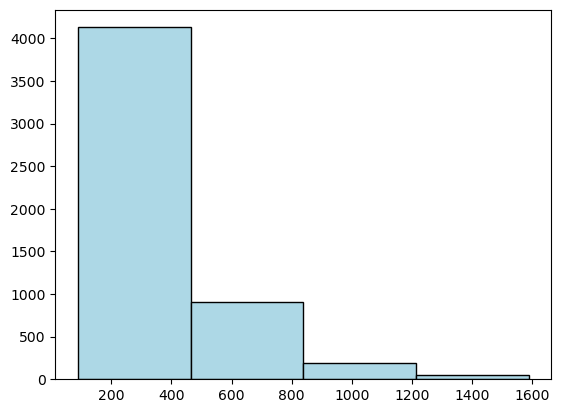

In [10]:
binsOption1 = pd.cut(prices, bins=len(priceLables) ,labels=priceLables, retbins=True)[1]
print(binsOption1)

plt.hist(prices, color = 'lightblue', ec='black', bins=binsOption1)
plt.show()

[  90.  175.  268.  434. 1588.]


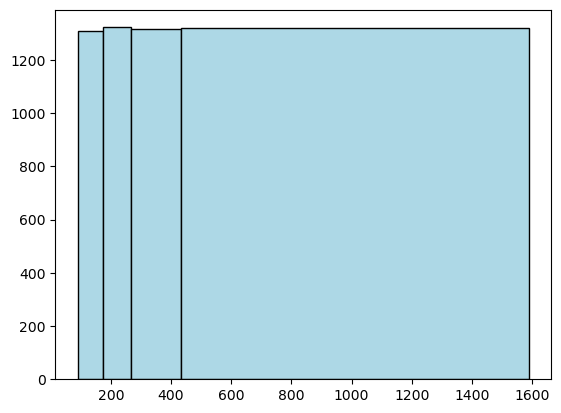

In [11]:
binsOption2 = pd.qcut(prices, len(priceLables) ,labels=priceLables, retbins=True)[1]
print(binsOption2)

plt.hist(prices, color = 'lightblue', ec='black', bins=binsOption2)
plt.show()

Selecting option 1

In [12]:
airbnb_df['price'] = pd.cut(prices, len(priceLables) ,labels=priceLables)
print(airbnb_df.head(5))
print("Data types for columns\n", airbnb_df.dtypes)

  price  room_shared  room_private  person_capacity  host_is_superhost  multi  \
0   low            0             1                2                  0      0   
1   low            0             1                2                  0      1   
2   low            0             1                3                  0      1   
3   low            0             1                2                  0      1   
4   low            0             0                3                  0      0   

   biz  cleanliness_rating  guest_satisfaction_overall  bedrooms  dist  \
0    0                   6                          69         1     5   
1    0                  10                          96         1     4   
2    0                  10                          95         1     4   
3    0                   9                          87         1     2   
4    1                   7                          65         0     4   

   metro_dist  attr_index  rest_index  room_type_Entire_home/apt  \


In [13]:
priceLabelData = airbnb_df['price']
airbnb_df['price'] = airbnb_df['price'].map(price_mapping)
print(airbnb_df.head(5))
print("Data types for columns\n", airbnb_df.dtypes)

  price  room_shared  room_private  person_capacity  host_is_superhost  multi  \
0     1            0             1                2                  0      0   
1     1            0             1                2                  0      1   
2     1            0             1                3                  0      1   
3     1            0             1                2                  0      1   
4     1            0             0                3                  0      0   

   biz  cleanliness_rating  guest_satisfaction_overall  bedrooms  dist  \
0    0                   6                          69         1     5   
1    0                  10                          96         1     4   
2    0                  10                          95         1     4   
3    0                   9                          87         1     2   
4    1                   7                          65         0     4   

   metro_dist  attr_index  rest_index  room_type_Entire_home/apt  \


In [14]:
Missing_values = airbnb_df.isnull().sum()
print("Missing values per column:")
print(Missing_values)
print(airbnb_df.shape)

Missing values per column:
price                         0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
rest_index                    0
room_type_Entire_home/apt     0
room_type_Private_room        0
room_type_Shared_room         0
dtype: int64
(5269, 17)


In [15]:
np.round(airbnb_df.describe(include='all'),decimals=3)

,price,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,room_type_Entire_home/apt,room_type_Private_room,room_type_Shared_room
count,5269.0,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000,5269.000
unique,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.005,0.545,2.847,0.167,0.277,0.361,9.195,90.917,1.123,4.805,0.561,293.577,624.348,0.451,0.545,0.005
std,NaN,0.067,0.498,1.238,0.373,0.448,0.480,1.145,11.238,0.565,2.653,1.206,167.379,383.023,0.498,0.498,0.067
min,NaN,0.000,0.000,2.000,0.000,0.000,0.000,2.000,20.000,0.000,0.000,0.000,68.000,140.000,0.000,0.000,0.000
25%,NaN,0.000,0.000,2.000,0.000,0.000,0.000,9.000,87.000,1.000,3.000,0.000,178.000,385.000,0.000,0.000,0.000
50%,NaN,0.000,1.000,2.000,0.000,0.000,0.000,10.000,94.000,1.000,4.000,0.000,248.000,528.000,0.000,1.000,0.000
75%,NaN,0.000,1.000,4.000,0.000,1.000,1.000,10.000,99.000,1.000,6.000,1.000,360.000,762.000,1.000,1.000,0.000


In [16]:
def logReg(train_X, valid_X, train_y, valid_y):
    logit_nom = LogisticRegression(penalty="l2", solver='lbfgs', 
               max_iter=15000, C=1e24, multi_class='multinomial')
    logit_nom.fit(train_X, train_y)


    print()
    print('Nominal Logistic Regression')
    print('  Intercepts', np.round(logit_nom.intercept_, decimals=3))
    print('  Coefficients', np.round(logit_nom.coef_, decimals=3))
    print()


    results_nom = logit_nom.predict(valid_X)
    prob_nom = np.round(logit_nom.predict_proba(valid_X), decimals = 4)


    print()
    print('Classification for First 10 Records in Validation Data Set')
    results_nom = pd.DataFrame({
        'Actual': valid_y, 'Classification': results_nom,
        'P(0)': [p[0] for p in prob_nom],
        'P(1)': [p[1] for p in prob_nom],
        'P(2)': [p[2] for p in prob_nom],
        'P(3)': [p[3] for p in prob_nom],
    })


    print(results_nom.head(10))
    
    print('Training Partition for Nominal Logistic Model')
    classificationSummary(train_y, logit_nom.predict(train_X))

    print()
    print('Validation Partition for Nominal Logistic Model')
    classificationSummary(valid_y, logit_nom.predict(valid_X))
    
    return (logit_nom, results_nom)

In [17]:
def printCharts(logResult, pString):
    print('Chart for ' + pString)
    df = logResult.sort_values(by=[pString], ascending=False)
    df['Actual'] = df['Actual'].astype(int)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    gainsChart(df['Actual'], ax=axes[0], color='Blue')
    liftChart(df[pString], title=False, ax=axes[1])
    plt.tight_layout()
    plt.show()

In [18]:
outcome = 'price'

X = airbnb_df.drop(columns=[outcome])
y = airbnb_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                            test_size=0.3, random_state=1)

logModel, logResult = logReg(train_X, valid_X, train_y, valid_y)


Nominal Logistic Regression
  Intercepts [ 5.225  0.928 -3.798 -2.355]
  Coefficients [[ 1.702e+00  1.990e+00 -2.540e-01 -3.060e-01  2.300e-02 -7.050e-01
  -9.700e-02 -6.000e-03 -1.646e+00  2.010e-01  8.480e-01 -3.000e-03
  -0.000e+00  1.533e+00  1.990e+00  1.702e+00]
 [-7.910e-01  5.260e-01  1.060e-01 -2.010e-01  1.070e-01 -1.410e-01
   5.200e-02 -7.000e-03 -4.310e-01  5.000e-03  5.890e-01 -1.000e-03
   0.000e+00  1.193e+00  5.260e-01 -7.910e-01]
 [-7.400e-01 -1.563e+00  1.290e-01 -2.620e-01 -1.430e-01  5.650e-01
   2.020e-01  1.100e-02  7.550e-01 -4.100e-02  9.300e-02  1.000e-03
   0.000e+00 -1.496e+00 -1.563e+00 -7.400e-01]
 [-1.710e-01 -9.540e-01  1.900e-02  7.690e-01  1.200e-02  2.820e-01
  -1.560e-01  1.000e-03  1.323e+00 -1.650e-01 -1.529e+00  3.000e-03
  -0.000e+00 -1.230e+00 -9.540e-01 -1.710e-01]]


Classification for First 10 Records in Validation Data Set
     Actual  Classification    P(0)    P(1)    P(2)    P(3)
736       1               1  0.9838  0.0158  0.0002  0.0001

Chart for P(0)


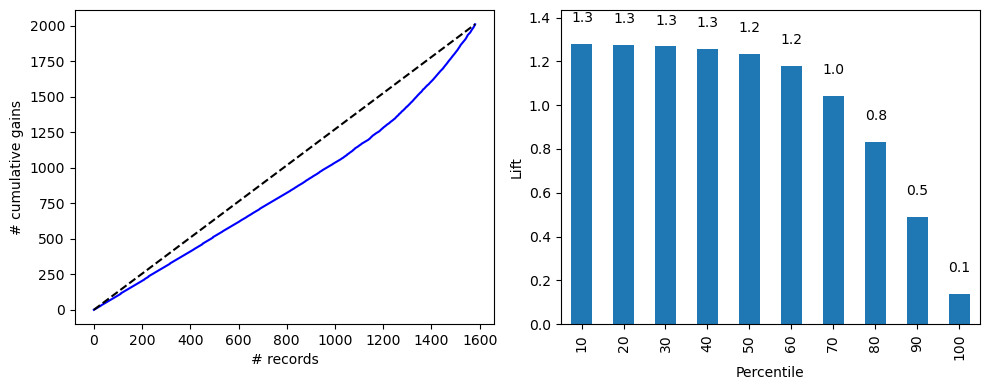

Chart for P(1)


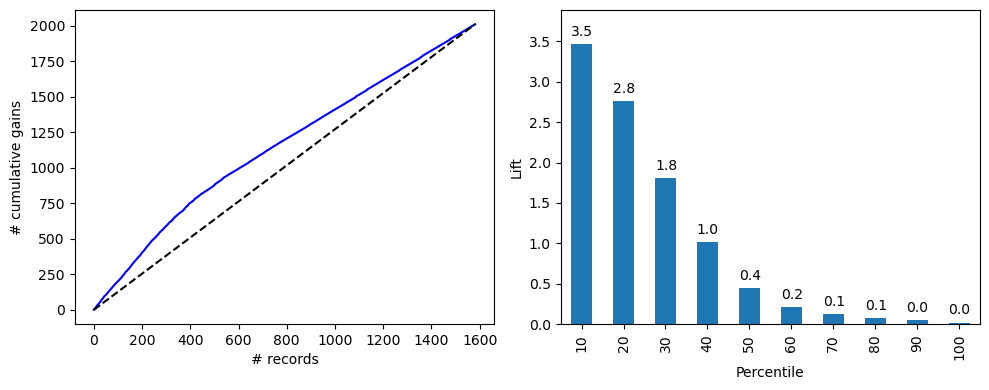

Chart for P(2)


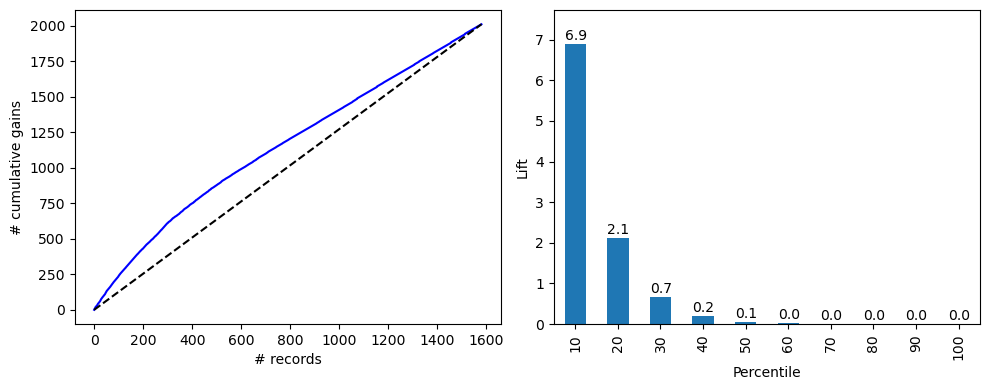

Chart for P(3)


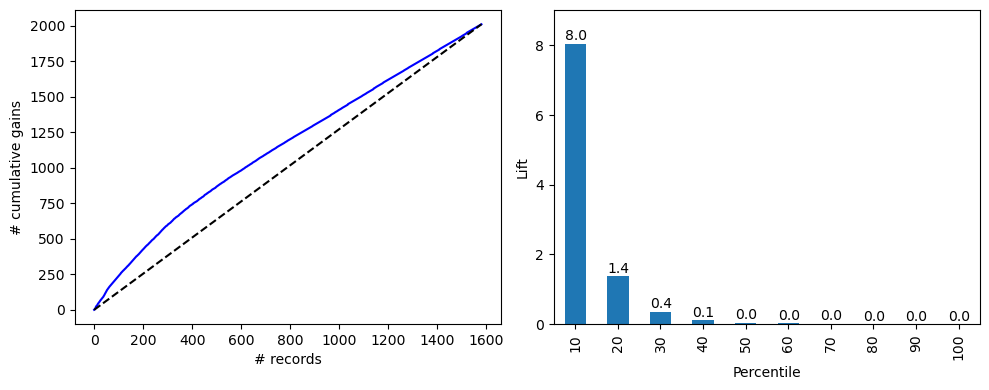

In [19]:
printCharts(logResult, 'P(0)')
printCharts(logResult, 'P(1)')
printCharts(logResult, 'P(2)')
printCharts(logResult, 'P(3)')

In [20]:
new_data = pd.DataFrame({
            'room_shared': [0, 1, 0],  
            'room_private': [1, 1, 1],
            'person_capacity': [2.0, 3.0, 6.0],
            'host_is_superhost': [1,0,0], 
            'multi': [0, 0, 0],
            'biz': [1, 0, 1],
            'cleanliness_rating': [5.0, 8.0, 10.0],  
            'guest_satisfaction_overall': [97, 85, 70],  
            'bedrooms': [1, 2, 5],  
            'dist': [4.49, 12.8, 1.49],
            'metro_dist': [0.73, 1.72, 5.42],
            'attr_index': [96.53, 165.40, 318.49],
            'rest_index' :[692.77,959.04,1021.27],
            'room_type_Entire_home/apt':[1,0,1],
            'room_type_Private_room':[1,0,0],
            'room_type_Shared_room':[1,0,0]
})
results_nom = logModel.predict(new_data)

pred_new_prob = np.round(logModel.predict_proba(new_data),
                    decimals = 4)

pred_new_result = new_data.copy()
pred_new_result['Classification'] = results_nom
pred_new_result['p(0)'] = [p[0] for p in pred_new_prob]
pred_new_result['p(1)'] = [p[1] for p in pred_new_prob]
pred_new_result['p(2)'] = [p[2] for p in pred_new_prob]
pred_new_result['p(3)'] = [p[3] for p in pred_new_prob]

print()
print('Classification using new Data')
print(pred_new_result)


Classification using new Data
   room_shared  room_private  person_capacity  host_is_superhost  multi  biz  \
0            0             1              2.0                  1      0    1   
1            1             1              3.0                  0      0    0   
2            0             1              6.0                  0      0    1   

   cleanliness_rating  guest_satisfaction_overall  bedrooms   dist  ...  \
0                 5.0                          97         1   4.49  ...   
1                 8.0                          85         2  12.80  ...   
2                10.0                          70         5   1.49  ...   

   attr_index  rest_index  room_type_Entire_home/apt  room_type_Private_room  \
0       96.53      692.77                          1                       1   
1      165.40      959.04                          0                       0   
2      318.49     1021.27                          1                       0   

   room_type_Shared_room  

In [21]:
def train_model(variables):
    model = LogisticRegression(penalty="l2", solver='lbfgs', 
               max_iter=15000, C=1e24, multi_class='multinomial')
    model.fit(train_X[variables], train_y)
    return model


def score_model(model, variables):
    return BIC_score(train_y, model.predict(train_X[variables]), model)

best_model_be, best_variables_be = backward_elimination(train_X.columns, 
                        train_model, score_model, verbose=True)

print()
print('Best Variables from Backward Elimination Algorithm')
print(best_variables_be)

Variables: room_shared, room_private, person_capacity, host_is_superhost, multi, biz, cleanliness_rating, guest_satisfaction_overall, bedrooms, dist, metro_dist, attr_index, rest_index, room_type_Entire_home/apt, room_type_Private_room, room_type_Shared_room
Start: score=4418.28
Step: score=4397.32, remove room_shared
Step: score=4349.73, remove room_type_Shared_room
Step: score=4349.73, remove None

Best Variables from Backward Elimination Algorithm
['room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'room_type_Entire_home/apt', 'room_type_Private_room']


In [22]:
outcome = 'price'

X = airbnb_df[best_variables_be]
y = airbnb_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                            test_size=0.3, random_state=1)

logReg(train_X, valid_X, train_y, valid_y)


Nominal Logistic Regression
  Intercepts [ 5.73   0.057 -3.565 -2.223]
  Coefficients [[ 1.039e+00 -2.660e-01 -2.840e-01  3.900e-02 -6.080e-01 -4.400e-02
  -2.000e-03 -1.561e+00  2.420e-01  7.930e-01 -2.000e-03 -0.000e+00
  -2.370e-01  1.039e+00]
 [ 8.970e-01  9.100e-02 -1.530e-01  9.700e-02 -1.400e-01  5.900e-02
  -7.000e-03 -4.030e-01 -5.000e-03  5.810e-01 -1.000e-03  0.000e+00
   2.039e+00  8.970e-01]
 [-1.131e+00  1.030e-01 -2.430e-01 -1.700e-01  5.150e-01  1.560e-01
   7.000e-03  7.960e-01 -7.100e-02  7.200e-02  0.000e+00  0.000e+00
  -6.780e-01 -1.131e+00]
 [-8.060e-01  7.300e-02  6.800e-01  3.400e-02  2.330e-01 -1.720e-01
   2.000e-03  1.169e+00 -1.660e-01 -1.447e+00  3.000e-03 -0.000e+00
  -1.125e+00 -8.060e-01]]


Classification for First 10 Records in Validation Data Set
     Actual  Classification    P(0)    P(1)    P(2)    P(3)
736       1               1  0.9820  0.0175  0.0004  0.0002
2120      2               2  0.4334  0.5137  0.0405  0.0124
4893      1               1

(LogisticRegression(C=1e+24, max_iter=15000, multi_class='multinomial'),
      Actual  Classification    P(0)    P(1)    P(2)    P(3)
 736       1               1  0.9820  0.0175  0.0004  0.0002
 2120      2               2  0.4334  0.5137  0.0405  0.0124
 4893      1               1  0.6830  0.2749  0.0373  0.0048
 1012      1               1  0.9468  0.0520  0.0011  0.0001
 5343      1               1  0.9766  0.0229  0.0004  0.0001
 ...     ...             ...     ...     ...     ...     ...
 3811      2               1  0.9441  0.0543  0.0016  0.0000
 3206      2               1  0.9977  0.0023  0.0000  0.0000
 2926      1               1  0.9747  0.0246  0.0005  0.0002
 1747      1               1  0.9838  0.0158  0.0003  0.0000
 4951      1               1  0.9820  0.0178  0.0002  0.0000
 
 [1581 rows x 6 columns])

Decision tree

In [23]:
airbnb_df['price'] = priceLabelData
print(airbnb_df.head(5))
print("Data types for columns\n", airbnb_df.dtypes)

  price  room_shared  room_private  person_capacity  host_is_superhost  multi  \
0   low            0             1                2                  0      0   
1   low            0             1                2                  0      1   
2   low            0             1                3                  0      1   
3   low            0             1                2                  0      1   
4   low            0             0                3                  0      0   

   biz  cleanliness_rating  guest_satisfaction_overall  bedrooms  dist  \
0    0                   6                          69         1     5   
1    0                  10                          96         1     4   
2    0                  10                          95         1     4   
3    0                   9                          87         1     2   
4    1                   7                          65         0     4   

   metro_dist  attr_index  rest_index  room_type_Entire_home/apt  \


In [24]:
outcome = 'price'

X = airbnb_df.drop(columns=[outcome])
y = airbnb_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                            test_size=0.3, random_state=1)

In [25]:
param_grid = {
    'max_depth': list(range(2, 25)), 
    'min_impurity_decrease': [0, 0.0005, 0.001], 
    'min_samples_split': list(range(5, 20)), 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print()
print(f'Improved score:{gridSearch.best_score_:.4f}')
print('Improved parameters: ', gridSearch.best_params_)


Improved score:0.8501
Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 5}


Best Classification Tree with Grid Search


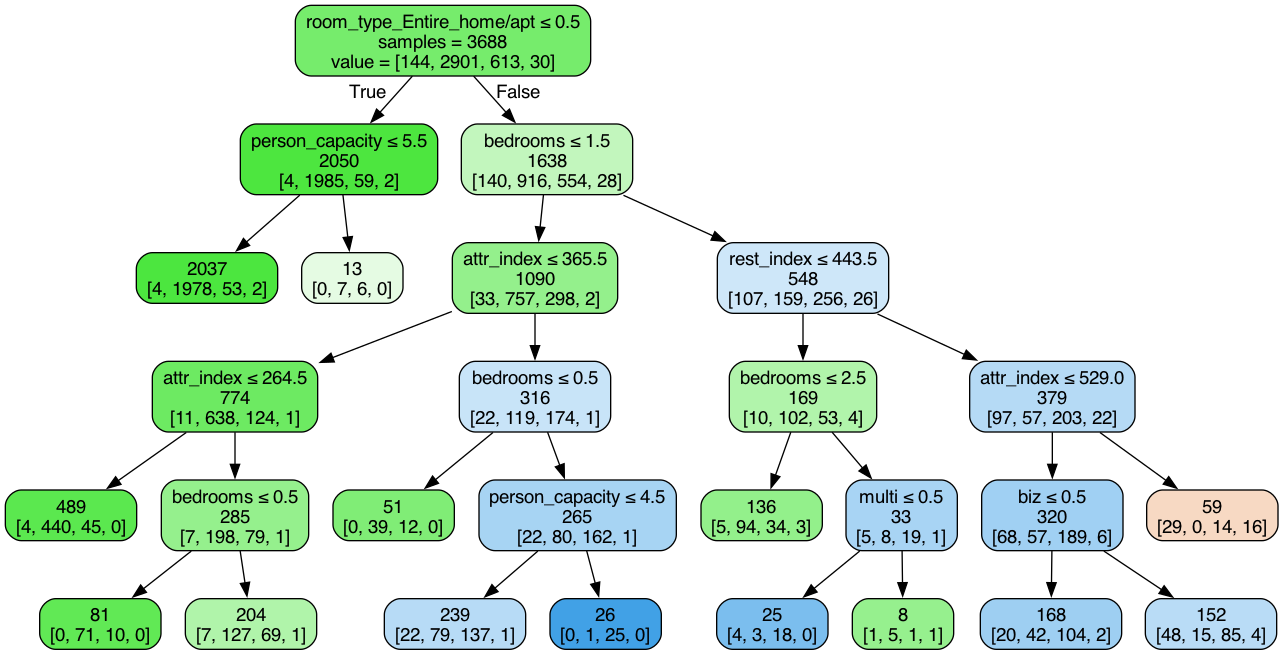

In [26]:
bestTree = gridSearch.best_estimator_

print('Best Classification Tree with Grid Search')
plotDecisionTree(bestTree, feature_names=train_X.columns)

In [27]:
print('Training Partition')
classificationSummary(train_y, bestTree.predict(train_X))
 
print()
print('Validation Partition')
classificationSummary(valid_y, bestTree.predict(valid_X))

Training Partition
Confusion Matrix (Accuracy 0.8566)

       Prediction
Actual    0    1    2    3
     0   29   21   94    0
     1    0 2761  140    0
     2   14  230  369    0
     3   16    7    7    0

Validation Partition
Confusion Matrix (Accuracy 0.8552)

       Prediction
Actual    0    1    2    3
     0    6    5   37    0
     1    0 1163   65    0
     2   10   97  183    0
     3    8    4    3    0


In [28]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(train_X, train_y)

# Display number of nodes in Random Forest trees.
n_nodes = rf.estimators_[0].tree_.node_count
print('Number of Nodes in Tree in Random Forest:', n_nodes)

print('Training Partition for Random Forests')
classificationSummary(train_y, rf.predict(train_X))

print()
print('Validation Partition for Random Forests')
classificationSummary(valid_y, rf.predict(valid_X))

Number of Nodes in Tree in Random Forest: 1083
Training Partition for Random Forests
Confusion Matrix (Accuracy 0.9878)

       Prediction
Actual    0    1    2    3
     0  140    2    2    0
     1    0 2895    6    0
     2    0   31  582    0
     3    1    3    0   26

Validation Partition for Random Forests
Confusion Matrix (Accuracy 0.8590)

       Prediction
Actual    0    1    2    3
     0   15    7   26    0
     1    2 1166   59    1
     2   20   95  175    0
     3    8    4    1    2


In [29]:
def importanceGraph(model, train_X):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    # Develop data frame for variable importance. The table data is sorted
    # in descending order (ascending=False).
    score_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': importances, 'Std': std})
    score_df = score_df.sort_values('Importance', ascending=False)

    # Display variable importance for Random Forest results. 
    print('Variable Importance Scores for Random Forest')
    print(score_df)
    
    score_df = score_df.sort_values('Importance')
    ax = score_df.plot(kind='barh', x='Feature')
    ax.set_ylabel('')
    plt.title('Variable Importance Plot')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

Variable Importance Scores for Random Forest
                       Feature  Importance       Std
12                  rest_index    0.195371  0.040127
11                  attr_index    0.189128  0.043653
2              person_capacity    0.112723  0.074369
13   room_type_Entire_home/apt    0.100683  0.085715
7   guest_satisfaction_overall    0.096149  0.014067
8                     bedrooms    0.084733  0.028016
9                         dist    0.048799  0.018016
1                 room_private    0.043937  0.073883
6           cleanliness_rating    0.042972  0.006803
5                          biz    0.026012  0.006723
4                        multi    0.017943  0.006711
3            host_is_superhost    0.016591  0.004575
10                  metro_dist    0.014459  0.001768
14      room_type_Private_room    0.009254  0.014707
15       room_type_Shared_room    0.000923  0.001111
0                  room_shared    0.000323  0.000567


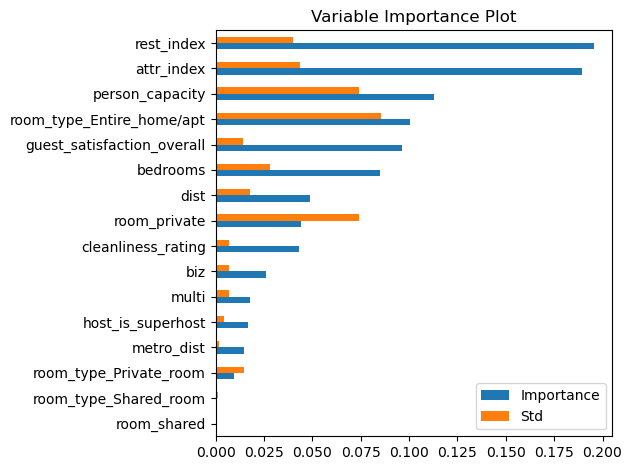

In [30]:
importanceGraph(rf, train_X)

In [31]:
boost = GradientBoostingClassifier(n_estimators=100, random_state=1)
boost.fit(train_X, train_y)

print('Training Partition for Boosted Tree')
classificationSummary(train_y, boost.predict(train_X))

print()
print('Validation Partition for Boosted Tree')
classificationSummary(valid_y, boost.predict(valid_X))

Training Partition for Boosted Tree
Confusion Matrix (Accuracy 0.9018)

       Prediction
Actual    0    1    2    3
     0   78   19   47    0
     1    0 2804   97    0
     2    3  191  419    0
     3    0    3    2   25

Validation Partition for Boosted Tree
Confusion Matrix (Accuracy 0.8672)

       Prediction
Actual    0    1    2    3
     0   10    9   28    1
     1    3 1171   53    1
     2   21   81  188    0
     3    6    4    3    2


In [32]:
new_data = pd.DataFrame({
            'room_shared': [0, 1, 0],  
            'room_private': [1, 1, 1],
            'person_capacity': [2.0, 3.0, 6.0],
            'host_is_superhost': [1,0,0], 
            'multi': [0, 0, 0],
            'biz': [1, 0, 1],
            'cleanliness_rating': [5.0, 8.0, 10.0],  
            'guest_satisfaction_overall': [97, 85, 70],  
            'bedrooms': [1, 2, 5],  
            'dist': [4.49, 12.8, 1.49],
            'metro_dist': [0.73, 1.72, 5.42],
            'attr_index': [96.53, 165.40, 318.49],
            'rest_index' :[692.77,959.04,1021.27],
            'room_type_Entire_home/apt':[1,0,1],
            'room_type_Private_room':[1,0,0],
            'room_type_Shared_room':[1,0,0]
})
results_tree = boost.predict(new_data)

pred_new_result = new_data.copy()
pred_new_result['Classification'] = results_tree

print()
print('Classification using new Data')
print(pred_new_result)


Classification using new Data
   room_shared  room_private  person_capacity  host_is_superhost  multi  biz  \
0            0             1              2.0                  1      0    1   
1            1             1              3.0                  0      0    0   
2            0             1              6.0                  0      0    1   

   cleanliness_rating  guest_satisfaction_overall  bedrooms   dist  \
0                 5.0                          97         1   4.49   
1                 8.0                          85         2  12.80   
2                10.0                          70         5   1.49   

   metro_dist  attr_index  rest_index  room_type_Entire_home/apt  \
0        0.73       96.53      692.77                          1   
1        1.72      165.40      959.04                          0   
2        5.42      318.49     1021.27                          1   

   room_type_Private_room  room_type_Shared_room Classification  
0                       1   